In [2]:
import sqlite3
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Caminho do banco de dados
db_path = 'C:/Users/Dell/Documents/2-PROJETOS EMBARCADOS/LEITURA_MODBUS_SERIAL/modbus_data1.db'

# Conexão com o banco de dados SQLite
con = sqlite3.connect(db_path)

# Consulta ajustada para obter valores de temperatura
query = "SELECT timestamp, value FROM reorganized_readings WHERE categoria = 'umidade'"

# Lê os dados do banco em um DataFrame
df = pd.read_sql_query(query, con)

# Fecha a conexão
con.close()

In [3]:
# ================================================
# 1) PRÉ-PROCESSAMENTO
# ================================================
# Remove valores nulos ou infinitos
df = df.dropna(subset=['value'])
df = df[df['value'].apply(np.isfinite)]

# Normaliza os dados para evitar influências de escala
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[['value']].values.reshape(-1, 1))

In [4]:
# ================================================
# 2) APLICAÇÃO DO DBSCAN
# ================================================
try:
    dbscan = DBSCAN(eps=0.5, min_samples=10000)  # Ajuste eps e min_samples conforme necessário
    labels = dbscan.fit_predict(data_scaled)
except MemoryError:
    print("Erro de memória ao executar DBSCAN. Tente reduzir os dados ou ajustar os parâmetros.")
    labels = []

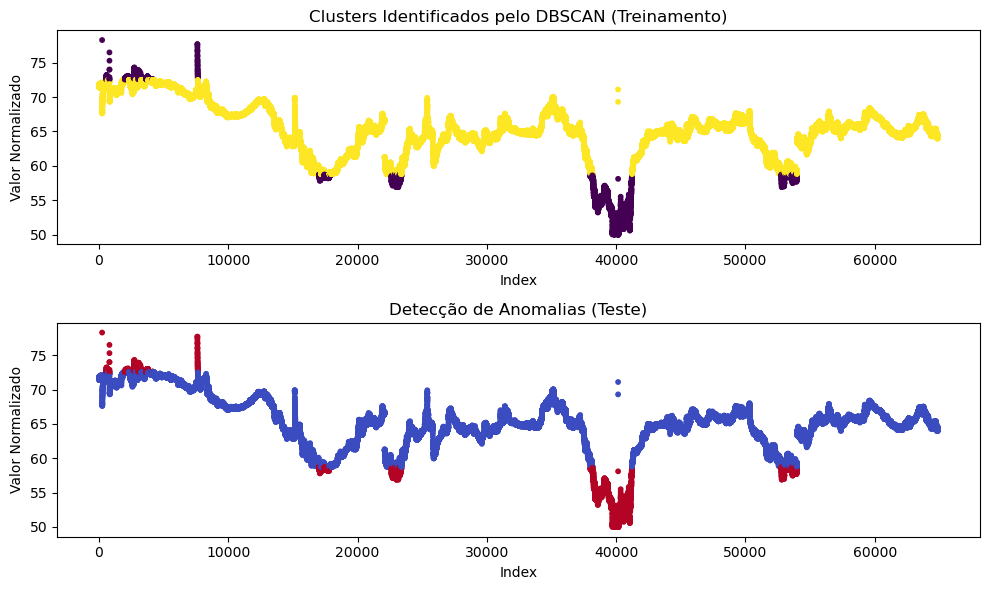

Leituras anômalas encontradas:
                 timestamp  value
242    2025-01-19 20:47:11   78.3
568    2025-01-19 21:16:00   72.6
569    2025-01-19 21:16:05   72.6
573    2025-01-19 21:16:25   72.6
574    2025-01-19 21:16:30   72.6
...                    ...    ...
53973  2025-01-24 14:02:37   58.4
53974  2025-01-24 14:02:42   58.4
53975  2025-01-24 14:02:47   58.5
53976  2025-01-24 14:02:52   58.6
53977  2025-01-24 14:02:57   58.7

[6087 rows x 2 columns]


In [5]:
# Adiciona as informações ao DataFrame, se possível
if len(labels) == len(df):
    df['Cluster'] = labels       # -1 indica ruído/anomalia
    df['Anomaly'] = (labels == -1)

    # ================================================
    # 3) CÁLCULO DE PORCENTAGEM DE ANOMALIAS
    # ================================================
    total_readings = len(df)
    total_anomalies = df['Anomaly'].sum()
    anomaly_percentage = (total_anomalies / total_readings) * 100

    

    # ================================================
    # 4) GRÁFICO DE TREINAMENTO E TESTE
    # ================================================
    plt.figure(figsize=(10, 6))

    # Gráfico de treinamento (clusters)
    plt.subplot(2, 1, 1)
    plt.scatter(df.index, df['value'], c=df['Cluster'], cmap='viridis', s=10)
    plt.title('Clusters Identificados pelo DBSCAN (Treinamento)')
    plt.xlabel('Index')
    plt.ylabel('Valor Normalizado')

    # Gráfico de teste (anomalias)
    plt.subplot(2, 1, 2)
    plt.scatter(df.index, df['value'], c=df['Anomaly'], cmap='coolwarm', s=10)
    plt.title('Detecção de Anomalias (Teste)')
    plt.xlabel('Index')
    plt.ylabel('Valor Normalizado')

    plt.tight_layout()
    plt.show()

   # ================================================
    # 5) RELATÓRIO DE ANOMALIAS
    # ================================================
    if 'Anomaly' in df.columns:
        anomalous_data = df[df['Anomaly']]
        print("Leituras anômalas encontradas:")
        print(anomalous_data[['timestamp', 'value']])

        # Visualização de parte dos resultados
      #  print("\nExemplo de leituras com clusters identificados:")
      #  print(df.head(10))
    else:
        print("Coluna 'Anomaly' não encontrada no DataFrame.")
else:
    print("Erro: Os labels gerados pelo DBSCAN não correspondem ao tamanho dos dados.")
